In [1]:
from block_methods import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
import matplotlib.colors as colors
from scipy import integrate,io

%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis([0, 0.6, 0.8]))

In [3]:
# set up matrix
Q = sp.io.mmread('matrices/figure_3.6.mtx')
del1 = np.matrix('0 0 1 0; 0 0 0 1; 1 0 0 0; 0 1 0 0')
P_tilde = np.kron(del1, np.eye(3))
P = np.kron(np.eye(np.shape(Q)[0]//12), P_tilde)

A = P@(np.eye(np.shape(Q)[0])-4/3*0.20611*Q)

Λ = np.linalg.eigvalsh(A)

In [4]:
b = [1, 2, 4, 8] # block size
step = 5
thresh = 1e-8

H = sp.sparse.spdiags(Λ,0,len(Λ),len(Λ))
λmin = np.min(Λ)
λmax = np.max(Λ)

n = len(Λ)

K = [1750, 1000, 575, 325]
w = 0

def f(x, a = w):
#     m is magnitude, default 1. 
#     s is shift, default 0.
    return (np.sign(x-a)+1)/2

angles = 0.5*np.pi # angle for D contour
r = 2*(λmax) # radius for D contour
lim = 10
np.random.seed(0)

hnorm = get_hnorm(Λ,lambda x: np.ones_like(x))

In [7]:
error_FAr = []
error_wLSr = []
error_absr = []
error_fullr = []
Kir = []

for i in range(len(b)):
   
    V = np.random.randn(n,b[i])
    # run Lanczos
    Q,Qkp1,A,B,B_0 = block_lanczos(H, V, K[i], K[i]+1)

    # generate tridiagonal matrix
    T = get_block_tridiag(A,B)
    
    orthTest(Q, b[i], K[i], thresh)
    threeTermTest(H, Q, T, Qkp1, B, b[i], K[i], thresh)

    fAV = np.diag(f(Λ))@V
    
    error_FA = np.full(10,np.nan)
    error_wLS = np.full(10,np.nan)
    error_abs = np.full(10,np.nan)
    error_full = np.full(10,np.nan)
    Ki = np.linspace(1, K[i]-1, 10, dtype = int)

    for j,k in enumerate(Ki): 

        print(i,j)

        T = get_block_tridiag(A[:k],B[:k])
        Eval,Evec = np.linalg.eigh(T)

        error_wLS[j] = hnorm((1/(Λ-w))[:,None]*V - get_lan_wLS(Eval, Evec, b[i], B_0, w, Q, k))

        lanf = get_lanf(Eval, Evec, b[i], B_0, f, Q, k)
        error_FA[j] = hnorm(fAV - lanf)
        
        pts = np.logspace(-15, -1, lim)
        error_abs[j] = get_trig_ineq_bound(pts, angles, r, Eval, Evec, b[i], B_0, λmin, f, w, w, Λ, V, Q, k, hnorm)
        error_full[j] = get_a_posteriori_bound(pts, angles, r, Eval, Evec, b[i], B_0, λmin, f, w, w, λmax) 
        
    error_FAr.append(error_FA)
    error_wLSr.append(error_wLS)
    error_absr.append(error_abs)
    error_fullr.append(error_full)
    Kir.append(Ki)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9


/home/tyler/Documents/Research Code/block_lanczos_CIF/block_methods/block_methods.py:305: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = sp.integrate.quad(a_posteriori_bound_integrand,0, angle, args=(Γ, angle, r, Eval, Evec, b, B_0, λmin, f, c, w, λmax))[0]
/home/tyler/Documents/Research Code/block_lanczos_CIF/block_methods/block_methods.py:306: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 

2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9


In [ ]:
np.save("data/figure_3.6/error_FAr", error_FAr)
np.save("data/figure_3.6/error_wLSr", error_wLSr)
np.save("data/figure_3.6/error_absr", error_absr)
np.save("data/figure_3.6/error_fullr", error_fullr)

# Uncomment the cell below to generate figures directly from data. 

In [ ]:
# error_FAr = np.load("data/figure_3.6/error_FAr.npy",allow_pickle=True)
# error_wLSr = np.load("data/figure_3.6/error_wLSr.npy",allow_pickle=True)
# error_absr = np.load("data/figure_3.6/error_absr.npy",allow_pickle=True)
# error_fullr = np.load("data/figure_3.6/error_fullr.npy",allow_pickle=True)

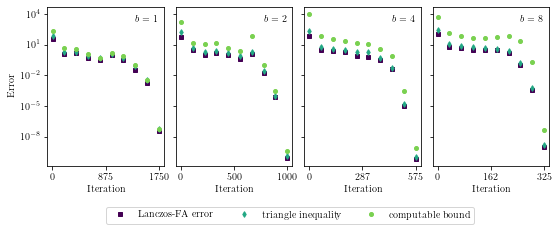

In [10]:
fig, axes = plt.subplots(1,4, figsize=(9,3.5), sharey = True)
plt.subplots_adjust(wspace=.1, hspace=.1,bottom=0.25)

for i in np.arange(4):
        axes[i].plot(Kir[i],error_FAr[i], ls='None', ms=4, marker = 's', label = 'Lanczos-FA error')
        axes[i].plot(Kir[i],error_absr[i], ls='None', ms=4, marker = 'd', label = 'triangle inequality')
        axes[i].plot(Kir[i],error_fullr[i]*error_wLSr[i], ls='None', ms=4, marker = 'o', label = 'computable bound')
        handles, labels = axes[i].get_legend_handles_labels()
        plt.yscale('log')
        axes[i].text(.95,.95,"$b = $ " + str(b[i]),ha='right', va='top', transform=axes[i].transAxes,bbox=dict(facecolor='white',edgecolor='none',pad=2))
        axes[i].set_xlabel('Iteration')
        axes[i].set_xticks([0, K[i]//2, K[i]])

axes[0].set_ylabel('Error')

plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,0),ncol=4)

plt.savefig("imgs/figure_3.6.pdf")